In [1]:
#!/usr/bin/env python

# MCS_Characteristics.ipynb

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import geopandas as gpd
from tqdm import tqdm

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


###  USER INPUT SECTION

In [2]:
FocMon=[1,2,3,4,5,6,7,8,9,10,11,12]

rgsDataSets=['IMERG','WRF4km']
rgsDataSetsNames=['Observation','South-America 4km']

sStat='seasons'
rgsSeas=['DJF','MAM','JJA','SON']

Grid = 'IMERG'  # options are ['Stage4', 'CONUS2_4km']
Data = 'WRF4'  # options are ['Stage4', 'CONUS2_4km']

sPlotDir='/glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/'

# set the font size
plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

# list of object properies
rgsPropertiesAll=['size','lifetime','speed','tracklength','maxPR','meanPR','totalPR','10-90%','ObjID']
rgsProperties=['size','speed','maxPR','meanPR','totalPR','lifetime','tracklength']

### Read in the constant fields

In [12]:
# IMERGE
ST4Data='/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/'
WY11 = pd.date_range(datetime.datetime(2010, 6, 1,0), end=datetime.datetime(2011, 5, 31,23), freq='h')
WY16 = pd.date_range(datetime.datetime(2015, 6, 1,0), end=datetime.datetime(2016, 5, 31,23), freq='h')
WY19 = pd.date_range(datetime.datetime(2018, 6, 1,0), end=datetime.datetime(2019, 5, 31,23), freq='h')
rgdTimeST4 = WY11.union(WY16).union(WY19)

WY11 = pd.date_range(datetime.datetime(2010, 6, 1,0), end=datetime.datetime(2011, 5, 31,23), freq='m')
WY16 = pd.date_range(datetime.datetime(2015, 6, 1,0), end=datetime.datetime(2016, 5, 31,23), freq='m')
WY19 = pd.date_range(datetime.datetime(2018, 6, 1,0), end=datetime.datetime(2019, 5, 31,23), freq='m')
TimeMM = WY11.union(WY16).union(WY19)

rgsYears = ['WY2011','WY2016','WY2019']

SEL=np.sum(np.array([(rgdTimeST4.month == FocMon[ii]) for ii in range(len(FocMon))]), axis=0)
rgdTimeST4=rgdTimeST4[SEL == 1]
iTimeS4 = np.array(range(len(rgdTimeST4)))
YYYY_ST4=np.unique(rgdTimeST4.year)
MinCov=0.8
# ds_disk = xr.open_dataset('/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/Andreas/prein_WY2011_OBS_SAAG-MCS-mask-file.nc')
# Lon=np.array(ds_disk['lon'])
# Lat=np.array(ds_disk['lat'])


ncid=Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2001/merg_2001123110_4km-pixel.nc', mode='r')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
ncid.close()
Lon,Lat = np.meshgrid(Lon,Lat)
# LatIM=LatIM[250:1050]
# LonIM=LonIM[900:1550]
# Lat,Lon=np.meshgrid(LatIM,LonIM)
# rgrLatST4 = Lat.T
# rgrLonST4 = Lon.T

# if Data == 'WRF4':
#     if Grid == 'IMERG':
#         C2Data='/glade/campaign/mmm/c3we/prein/Papers/2020_SouthAmerica/data/TrackAnalysis/'
#     rgdTimeC2 = pd.date_range(datetime.datetime(2018, 6, 1,0), end=datetime.datetime(2019, 5, 31,23), freq='h')
#     SEL=np.sum(np.array([(rgdTimeC2.month == FocMon[ii]) for ii in range(len(FocMon))]), axis=0)
#     rgdTimeC2=rgdTimeC2[SEL == 1]
#     YYYY_C2=np.unique(rgdTimeC2.year)
# if Grid == 'IMERG':
#     rgrLatC2 = np.copy(rgrLatST4)
#     rgrLonC2 = np.copy(rgrLonST4)
#     rgrLatC1 = np.copy(rgrLatST4)
#     rgrLonC1 = np.copy(rgrLonST4)

### load the shape files that we want to use for the regional analysis

In [4]:
# sUSSubregions='/glade/u/home/prein/papers/2020_SouthAmerica/Shapefiles/amapoly_ivb'
# ctr = shapefile.Reader(sUSSubregions)
# geomet = ctr.shapeRecords() #will store the geometry separately
# grShapeFiles={}
# for sh in range(len(geomet)):
#     first = geomet[sh]
#     grShapeFiles[first.record[5]]=first.shape.points
# grShapeFiles = {"Amazon Basin" if k == 6725344251419.7 else k:v for k,v in grShapeFiles.items()}


# sUSSubregions='/glade/u/home/prein/papers/2020_SouthAmerica/Shapefiles/LaPlata_fin'
# ctr = shapefile.Reader(sUSSubregions)
# geomet = ctr.shapeRecords() #will store the geometry separately
# for sh in range(len(geomet)):
#     first = geomet[sh]
#     grShapeFiles['LaPlata_fin']=first.shape.points

# sUSSubregions='/glade/u/home/prein/papers/2020_SouthAmerica/Shapefiles/Columbia_fin'
# ctr = shapefile.Reader(sUSSubregions)
# geomet = ctr.shapeRecords() #will store the geometry separately
# for sh in range(len(geomet)):
#     first = geomet[sh]
#     grShapeFiles['Columbia_fin']=first.shape.points
    
    
# # sCanadaMexico='/glade/u/home/prein/papers/2020_CONUS2_MCSs/ShapeFiles/Canada-Mexico'
# # ctr = shapefile.Reader(sCanadaMexico)
# # geomet = ctr.shapeRecords()
# # for sh in range(len(geomet)):
# #     first = geomet[sh]
# #     grShapeFiles[first.record[4]]=first.shape.points

In [5]:
sShapefiles='/glade/u/home/prein/papers/2020_SouthAmerica/Shapefiles/AR6/IPCC-AR6_SouthAmerica_fin.shp'
Regions = ['SCA','CAR','NWS','NSA','NES','SAM','SWS','SES','SSA','EPO','SPO','NAO','EAO','SAO']
SelRegions = ['NWS','NSA','SAM','NES','SES','NAO','EAO','SAO']
sRegNames=Regions
data = gpd.read_file(sShapefiles)
# change CRS to epsg 4326
Shapes = data.to_crs(epsg=4326)

grShapeFiles={}
Coordinates = data['geometry']
for sf in tqdm(range(len(data))):
    x, y = Coordinates[sf].exterior.coords.xy
    TEST = np.array([x,y]).T
    if Regions[sf] in SelRegions:
        grShapeFiles[Regions[sf]]=TEST

100%|██████████| 14/14 [00:00<00:00, 1382.04it/s]


### Calculate the Statistics

In [14]:
# Read in Stage IV MCS characteristics
MCSsPerMonthS4 = np.zeros((len(YYYY_ST4),len(FocMon),len(grShapeFiles.keys())))
MCSsPerHour_MM = np.zeros((len(YYYY_ST4),len(FocMon),24,len(grShapeFiles.keys())))
StormSpeedS4 = {}
StormLatS4 = {}
StormLonS4 = {}
StormSizeS4 = {}
PRpercS4 = {}
PRvolS4 = {}
PRmeanS4 = {}
PRmaxS4 = {}


StormLatS4All = {}
StormLonS4All = {}
# Data for tracking visualization
S4MCStime = list() #np.zeros((1000,300)); S4MCStime[:]=np.nan
S4LatMCS = list()
S4LonMCS = list()
# 'rgrSize', 'rgrPR_Percentiles', 'rgrPR_Vol', 'rgrPR_Mean', 'rgrMassCent', 'rgrObjSpeed', 'rgrAccumulation', 'rgrPR_Max'
ii = 0
for yy in range(len(YYYY_ST4)):
    print('    ST4 year '+str(YYYY_ST4[yy]))
#     for mm in range(len(FocMon)):
#     FILE=ST4Data+str('WY'+str(YYYY_ST4[yy])+'_IMERG-MERGIR_Prein_SAAG-MCS-tracking.nc_MCS_'+str(int(YYYY_ST4[yy])-1)+'06.pkl')
    FILE = ST4Data+str('IMERG-MERGIR_MCS_'+str(int(YYYY_ST4[yy])-1)+'06.pkl')
    if os.path.isfile(FILE) == True:
        file = open(FILE, 'rb')
        DATA=pickle.load(file, encoding='latin1')
        Objects=np.array(list(DATA.keys()))
        for ob in range(len(DATA.keys())):
            OBact=DATA[Objects[ob]]
            Location=OBact['track']; Location=Location[~np.isnan(Location[:,0]),:]
            LAT = Location[:,0]
            LON = Location[:,1]
            SPEED=OBact['speed']
            FIN = ~np.isnan(SPEED)
            SPEED=SPEED[FIN]
            ObID=str(YYYY_ST4[yy])+'06_'+str(ob).zfill(3)
            TIME = pd.to_datetime(OBact['times'])
            iTimeTmp = iTimeS4[np.where(rgdTimeST4 == TIME[0])[0][0] : np.where(rgdTimeST4 == TIME[-1])[0][0]+1]
            S4MCStime.append(iTimeTmp)
            S4LatMCS.append(LAT)
            S4LonMCS.append(LON)

            StormLatS4All[ObID] = LAT
            StormLonS4All[ObID] = LON
            ii = ii + 1
            stop()
            for sr in range(len(grShapeFiles.keys())):
                rgrPoly=grShapeFiles[list(grShapeFiles.keys())[sr]]
                # ActShape = shapely.geometry.Polygon(rgrPoly)
                ActShape =mplPath.Path(rgrPoly)
                rStormContained=[ActShape.contains_point((LON[pp], LAT[pp])) for pp in range(len(LAT))]
                if np.sum(rStormContained) >= len(rStormContained)/2:
                    mm = int(np.median(TIME.month)-1)
                    MCSsPerMonthS4[yy,mm,sr] = MCSsPerMonthS4[yy,mm,sr]+1
                    StormSpeedS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID]=SPEED
                    StormLatS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = LAT
                    StormLonS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = LON
                    StormSizeS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['size']
#                         PRpercS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['rgrPR_Percentiles']
                    PRvolS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['tot']
                    PRmeanS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['mean']
                    PRmaxS4[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['max']      
                    # get frequency of MCSs per hour
                    rgiHours = OBact['times'].hour 
                    rgiHours = np.array([np.sum(rgiHours == ii) for ii in range(24)])
                    MCSsPerHour_MM[yy,mm,:,sr] = rgiHours + MCSsPerHour_MM[yy,mm,:,sr]
    else:
        print('        File missing '+str(FILE))
#         MCSsPerMonthS4[yy,mm,:] = np.nan

MCSsPerMonthS4[0::2,:] = np.nan
MCSsPerHour_MM[0::2,:,:] = np.nan
MCSsPerHour_MM[2:,:,:] = np.nan

    ST4 year 2010
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_200906.pkl
    ST4 year 2011
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_201006.pkl
    ST4 year 2015
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_201406.pkl
    ST4 year 2016
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_201506.pkl
    ST4 year 2018
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_201706.pkl
    ST4 year 2019
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/IMERG-MERGIR_MCS_201806.pkl


In [8]:
# Read in CONUS404 MCS characteristics
MCSsPerMonthC2=np.zeros((len(YYYY_ST4),len(FocMon),len(grShapeFiles.keys())))
MCSsPerHour_MM_Mod = np.zeros((len(YYYY_ST4),len(FocMon),24,len(grShapeFiles.keys())))
StormSpeedC2 = {}
StormLatC2 = {}
StormLonC2 = {}
StormSizeC2 = {}
PRpercC2 = {}
PRvolC2 = {}
PRmeanC2 = {}
PRmaxC2 = {}

StormLatC2All = {}
StormLonC2All = {}
# Data for tracking visualization
C2MCStime = list() #np.zeros((1000,300)); S4MCStime[:]=np.nan
C2LatMCS = list()
C2LonMCS = list()
for yy in range(len(YYYY_ST4)):
    print('    C2 year '+str(YYYY_ST4[yy]))
#     for mm in range(len(FocMon)):
#     print('        C2 month '+str(FocMon[mm]))
#     FILE=ST4Data+str('WY'+str(YYYY_ST4[yy])+'_SAAG-WRF4_Prein_SAAG-MCS-tracking.nc_MCS_'+str(YYYY_ST4[yy]-1)+'06.pkl')
    FILE = ST4Data+str('SAAG-WRF4_MCS_'+str(int(YYYY_ST4[yy])-1)+'06.pkl')
    if os.path.isfile(FILE) == True:
        file = open(FILE, 'rb')
        DATA=pickle.load(file, encoding='latin1')
        Objects=np.array(list(DATA.keys()))
        for ob in range(len(DATA.keys())):
            OBact=DATA[Objects[ob]]
            Location=OBact['track']; Location=Location[~np.isnan(Location[:,0]),:]
            LAT = Location[:,0]
            LON = Location[:,1]
            SPEED=OBact['speed']
            FIN = ~np.isnan(SPEED)
            SPEED=SPEED[FIN]
            ObID=str(YYYY_ST4[yy])+'06_'+str(ob).zfill(3)
            TIME = pd.to_datetime(OBact['times'])
            iTimeTmp = iTimeS4[np.where(rgdTimeST4 == TIME[0])[0][0] : np.where(rgdTimeST4 == TIME[-1])[0][0]+1]
            C2MCStime.append(iTimeTmp)
            C2LatMCS.append(LAT)
            C2LonMCS.append(LON)
            StormLatC2All[ObID] = LAT
            StormLonC2All[ObID] = LON
            ii = ii + 1
            for sr in range(len(grShapeFiles.keys())):
                rgrPoly=grShapeFiles[list(grShapeFiles.keys())[sr]]
                # ActShape = shapely.geometry.Polygon(rgrPoly)
                ActShape =mplPath.Path(rgrPoly)
                rStormContained=[ActShape.contains_point((LON[pp], LAT[pp])) for pp in range(len(LAT))]
                if np.sum(rStormContained) >= len(rStormContained)/2:
                    mm = int(np.median(TIME.month)-1)
                    MCSsPerMonthC2[yy,mm,sr] = MCSsPerMonthC2[yy,mm,sr]+1
                    StormSpeedC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID]=SPEED
                    StormLatC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = LAT
                    StormLonC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = LON
                    StormSizeC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['size']
#                         PRpercC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['rgrPR_Percentiles']
                    PRvolC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['tot']
                    PRmeanC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['mean']
                    PRmaxC2[np.array(list(grShapeFiles.keys()))[sr]+'_'+ObID] = OBact['max']     
                    # get frequency of MCSs per hour
                    rgiHours = OBact['times'].hour 
                    rgiHours = np.array([np.sum(rgiHours == ii) for ii in range(24)])
                    MCSsPerHour_MM_Mod[yy,mm,:,sr] = rgiHours + MCSsPerHour_MM_Mod[yy,mm,:,sr]
    else:
        print('        File missing '+str(FILE))
#         MCSsPerMonthC2[yy,mm,:] = np.nan
MCSsPerMonthC2[0::2,:] = np.nan
MCSsPerHour_MM_Mod[0::2,:,:] = np.nan
MCSsPerHour_MM_Mod[2:,:,:] = np.nan

    C2 year 2010
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/tests2/SAAG-WRF4_MCS_200906.pkl
    C2 year 2011
    C2 year 2015
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/tests2/SAAG-WRF4_MCS_201406.pkl
    C2 year 2016
    C2 year 2018
        File missing /glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/My-Track-Results/tests2/SAAG-WRF4_MCS_201706.pkl
    C2 year 2019


### PRINT RESULTS

No handles with labels found to put in legend.


        Plot map to: /glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/StormAnnualCycle_Characteristics_5mm_Sigma3_3000GC.pdf


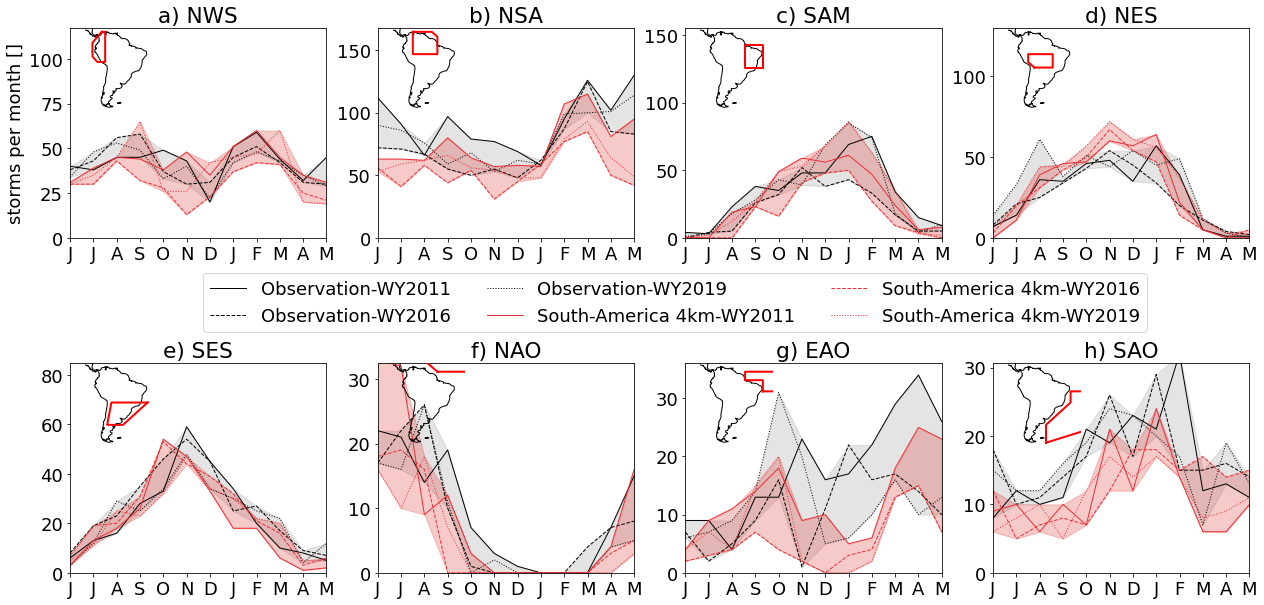

In [9]:
rgrColors=['#000000','#ee2f35','#1f78b4','#ff7f00'] #['#000000','#4459a6','#ee2f35']
rgrColorsAll=np.array([['#737373','#969696','#252525'],
              ['#fb6a4a','#de2d26','#cb181d'],
              ['#fb6a4a','#1f78b4','#cb181d'],
              ['#fb6a4a','#ff7f00','#cb181d']])
rgsRegions = list(grShapeFiles.keys())

import cartopy.crs as ccrs
fig = plt.figure(figsize=(18,9))
# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(2,4) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.6)

LineStyle = ['-','--',':']
XX = [0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1]
for sr in range(len(SelRegions)): #range(rgiSize[2]):
    rgrShapeAct=np.array(grShapeFiles[rgsRegions[sr]])
    iSR=list(grShapeFiles.keys()).index(rgsRegions[sr])
    for pl in [0]: #range(3):
        ax = plt.subplot(gs1[YY[sr],XX[sr]])
        for da in [0,1]: #range(len(rgsDataSets)):
            if da == 0:
                iLineW=4
                DATA = np.copy(MCSsPerMonthS4[:,:,sr])
            elif da == 1:
                iLineW=2
                DATA = np.copy(MCSsPerMonthC2[:,:,sr])
            elif da == 2:
                iLineW=2
                DATA = np.copy(MCSsPerMonthC1[:,:,sr])
            elif da == 3:
                iLineW=2
                DATA = np.copy(MCSsPerMonthC2S[:,:,sr])
            if pl == 0:
                # storm cound
                rgrDataAct= np.nanpercentile(DATA[1::2], (0,50,100), axis=0)
                rgrDataHigh=rgrDataAct[2,:]
                rgrDataLow=rgrDataAct[0,:]
                rgrDataAct=rgrDataAct[1,:]
                xLable=''
                yLable='storms per month []'
                sTitle=SelRegions[sr]
            elif pl == 1:
                # total average precipitatoin
                rgrDataAct=np.array(stats.mstats.mquantiles(rgrPRstatisticSR[:,:,sr,0,da],prob=[0.25, 0.5, 0.75], axis=0))*24.
                rgrDataHigh=rgrDataAct[2,:]
                rgrDataLow=rgrDataAct[0,:]
                rgrDataAct=rgrDataAct[1,:]
                xLable=''
                yLable='mean precip. [mm d$^{-1}$]'
                sTitle=' '
            elif pl == 2:
                xLable='month []'
                yLable='precip. from storms [%]'
                rgrDataDummy=(rgrPRstatisticSR[:,:,sr,1,da]/rgrPRstatisticSR[:,:,sr,0,da])*100.
                rgrDataAct=np.array(stats.mstats.mquantiles(rgrDataDummy,prob=[0.25, 0.5, 0.75], axis=0))
                rgrDataHigh=rgrDataAct[2,:]
                rgrDataLow=rgrDataAct[0,:]
                rgrDataAct=rgrDataAct[1,:]
                sTitle=' '

            ax.fill_between((np.array(range(rgiSize[1]))), np.roll(rgrDataLow,5), np.roll(rgrDataHigh,5), alpha=0.25, color=rgrColorsAll[da,1])
            for yy in range(len(rgsYears)):
                YY_data = DATA[yy*2+1,:].flatten()
#                 YY_data = YY_data[~np.isnan(YY_data)]
                YY_data = np.roll(YY_data,5)
#                 if len(YY_data) != 12:
#                     continue
                plt.plot(range(12), YY_data, ls=LineStyle[yy], color=rgrColors[da],lw=1, 
                         label=rgsDataSetsNames[da]+'-'+rgsYears[yy])
            if sr == 0:
                plt.legend(bbox_to_anchor=(4.2, -0.45), loc='lower right', borderaxespad=0., ncol=3)
            
#             ax.plot(rgrDataAct, ls='-', color=rgrColors[da],lw=iLineW, label=rgsDataSetsNames[da])

            ax.set_xlabel(xLable)
            if sr == 0:
                ax.set_ylabel(yLable)
            ax.set_xlim([0,11])
            ax.xaxis.set_ticks(range(12))
            ax.set_xticklabels(['J','J','A','S','O','N','D','J','F','M','A','M'])
            plt.title(rgsLableABC[sr]+') '+sTitle)
            ax.set_ylim([0,np.nanmax(YY_data)*1.8])
        if pl ==0:
            # inlay showing the subregion
            pos1 = np.array(ax.get_position())
            xSize=pos1[1][0]-pos1[0][0]
            ySize=pos1[1][1]-pos1[0][1]
            proj = ccrs.PlateCarree() #ccrs.Robinson() 
            ax = plt.axes([pos1[0][0]+xSize*0,
                          pos1[0][1]+ySize*0.60,
                          xSize*0.4,
                          ySize*0.4,
                          ], projection=proj) #, axisbg='y')

            # a = plt.axes([0.09+(sr*0.24), 0.75, 0.2, 0.17], axisbg='y')
            plt.axis('off')
#             m = Basemap(projection='cyl',\
#                     llcrnrlat= -60 ,urcrnrlat=15,\
#                     llcrnrlon=-90,urcrnrlon=-25,resolution='l')
            ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
            ax.coastlines()
#             xi,yi=m()
#             m.scatter(xi,yi,c='red', marker='o', linewidth=0,s=4)
            ax.plot(rgrShapeAct[:,0], rgrShapeAct[:,1],c='red', linewidth=2, transform=ccrs.PlateCarree())
            if sr == 0:
                # add legend
                # ax.legend(loc='lower right', frameon=False)
                ax.legend(loc='lower center',
                          ncol=1, frameon=False) #, bbox_to_anchor=(0.5, -0.35)

        # Lable the map
        # ax.text(0.085,0.95, rgsSeas[se], ha='left',va='center', transform = ax.transAxes)


# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'StormAnnualCycle_Characteristics_5mm_Sigma3_3000GC.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
# fig.savefig(sPlotFile+sPlotName, dpi=700)


### Plot the dirunal cycle of MCSs

        Plot map to: /glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/StormDiurnalCycle_Characteristics_5mm_Sigma3_3000GC.pdf


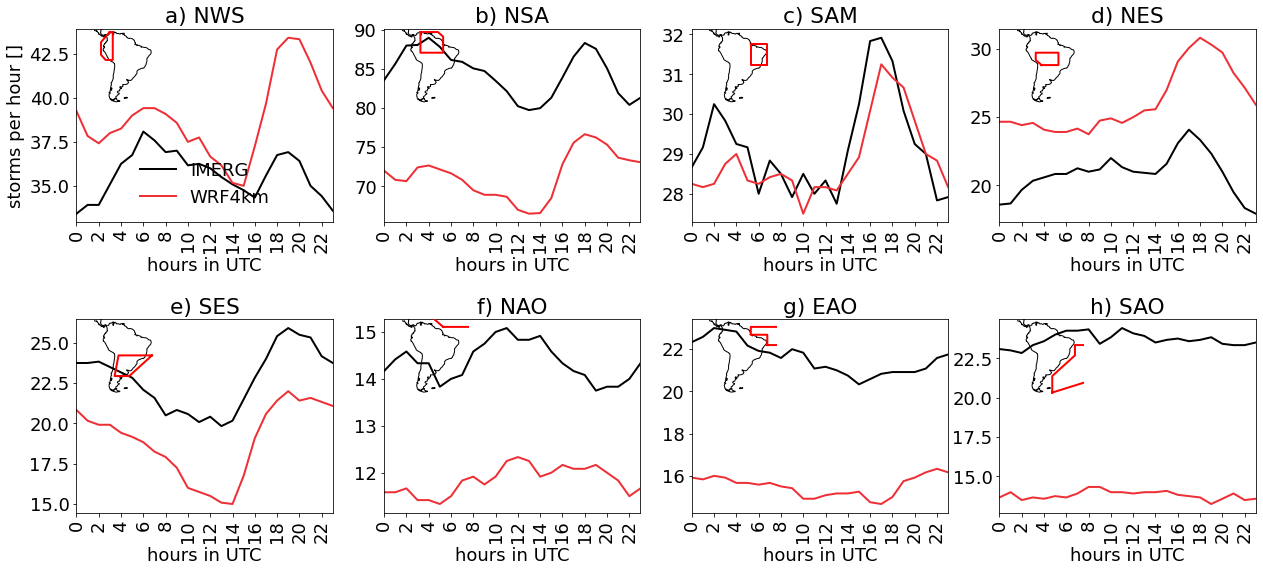

In [10]:
rgrColors=['#000000','#ee2f35','#1f78b4','#ff7f00'] #['#000000','#4459a6','#ee2f35']
rgrColorsAll=np.array([['#737373','#969696','#252525'],
              ['#fb6a4a','#de2d26','#cb181d'],
              ['#fb6a4a','#1f78b4','#cb181d'],
              ['#fb6a4a','#ff7f00','#cb181d']])
rgsRegions = list(grShapeFiles.keys())

import cartopy.crs as ccrs
fig = plt.figure(figsize=(18,8))
# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(2,4) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.5)

XX = [0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1]
for sr in range(len(SelRegions)): #range(rgiSize[2]):
    rgrShapeAct=np.array(grShapeFiles[rgsRegions[sr]])
    iSR=list(grShapeFiles.keys()).index(rgsRegions[sr])

    ax = plt.subplot(gs1[YY[sr],XX[sr]])
    for da in [0,1]: #range(len(rgsDataSets)):
        if da == 0:
            iLineW=4
            DATA = np.nanmean(MCSsPerHour_MM[:,:,:,sr], axis=(0,1))
        elif da == 1:
            iLineW=2
            DATA = np.nanmean(MCSsPerHour_MM_Mod[:,:,:,sr], axis=(0,1))
        
        xLable='hours in UTC'
        yLable='storms per hour []'
        sTitle=SelRegions[sr]

        plt.plot(range(24), DATA, ls='-', color=rgrColors[da],lw=2, 
                 label=rgsDataSets[da])

    ax.set_xlabel(xLable)
    if sr == 0:
        ax.set_ylabel(yLable)
    ax.set_xlim([0,23])
    plt.xticks(rotation = 90)
    ax.xaxis.set_ticks(range(0,24,2))
    plt.title(rgsLableABC[sr]+') '+sTitle)
#     ax.set_ylim([0,np.max(DATA)*1.35])
    
    if sr == 0:
        ax.legend(loc='lower center',
                  ncol=1, frameon=False)


    # inlay showing the subregion
    pos1 = np.array(ax.get_position())
    xSize=pos1[1][0]-pos1[0][0]
    ySize=pos1[1][1]-pos1[0][1]
    proj = ccrs.PlateCarree() #ccrs.Robinson() 
    ax = plt.axes([pos1[0][0]+xSize*0,
                  pos1[0][1]+ySize*0.60,
                  xSize*0.4,
                  ySize*0.4,
                  ], projection=proj) #, axisbg='y')

    plt.axis('off')
    ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
    ax.coastlines()
    
    ax.plot(rgrShapeAct[:,0], rgrShapeAct[:,1],c='red', linewidth=2, transform=ccrs.PlateCarree(), label=rgsDataSets[da])
    
# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'StormDiurnalCycle_Characteristics_5mm_Sigma3_3000GC.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
# fig.savefig(sPlotFile+sPlotName, dpi=700)


### Print MCS characteridtics

In [11]:
REG='SES'
# ["Amazon Basin",'LaPlata_fin','Columbia_fin']

# Process Stage IV
MCSs=np.array(list(StormSizeS4.keys()))
SelReg=[REG in MCSs[ii] for ii in range(len(MCSs))]
MCSReg=MCSs[SelReg]
SizeRegS4=np.zeros((np.sum(SelReg),300)); SizeRegS4[:]=np.nan
SpeedS4=np.copy(SizeRegS4)
MAXS4 = np.copy(SizeRegS4)
MEANS4 = np.copy(SizeRegS4)
VOLS4 = np.copy(SizeRegS4)
for mc in range(SizeRegS4.shape[0]):
    SizeAct=StormSizeS4[MCSReg[mc]]
    SizeRegS4[mc,:len(SizeAct)]=SizeAct
    SpeedAct=StormSpeedS4[MCSReg[mc]]
    SpeedS4[mc,:len(SpeedAct)]=SpeedAct
    MAXact = PRmaxS4[MCSReg[mc]]
    MAXS4[mc,:len(MAXact)]=MAXact
    MEANact = PRmeanS4[MCSReg[mc]]
    MEANS4[mc,:len(MEANact)]=MEANact
    VOLact=PRvolS4[MCSReg[mc]]
    VOLS4[mc,:len(VOLact)]=VOLact

SIZE_S4=SizeRegS4[~np.isnan(SizeRegS4)]
SPEED_S4=SpeedS4[~np.isnan(SpeedS4)]
MAX_S4 = MAXS4[~np.isnan(MAXS4)]
MEAN_S4 = MEANS4[~np.isnan(MEANS4)]
VOL_S4 = VOLS4[~np.isnan(VOLS4)]#/(1000*1000*1000)
Duration_S4 = np.array([np.sum(~np.isnan(MEANS4[ii,:])) for ii in range(VOLS4.shape[0])])

# Process CONUS404
MCSs=np.array(list(StormSizeC2.keys()))
SelReg=[REG in MCSs[ii] for ii in range(len(MCSs))]
MCSReg=MCSs[SelReg]
SizeRegC2=np.zeros((np.sum(SelReg),300)); SizeRegC2[:]=np.nan
SpeedC2 = np.copy(SizeRegC2)
MAXC2 = np.copy(SizeRegC2)
MEANC2 = np.copy(SizeRegC2)
VOLC2 = np.copy(SizeRegC2)
for mc in range(SizeRegC2.shape[0]):
    SizeAct=StormSizeC2[MCSReg[mc]]
    SpeedAct=StormSpeedC2[MCSReg[mc]]
    MAXAct = PRmaxC2[MCSReg[mc]]
    MEANAct = PRmeanC2[MCSReg[mc]]
    VOLact = PRvolC2[MCSReg[mc]]
    try:
        SizeRegC2[mc,:]=SizeAct[:SizeRegC2.shape[1]]
        SpeedC2[mc,:]=SpeedAct[:SpeedC2.shape[1]]
        MAXC2[mc,:]=MAXAct[:MAXC2.shape[1]]
        MEANC2[mc,:]=MEANAct[:MEANC2.shape[1]]
        VOLC2[mc,:]=VOLact[:VOLC2.shape[1]]
    except:
#     max_len = np.min([len(SizeAct),SizeRegC2.shape[1]])-1
#     SizeRegC2[mc,:max_len]=SizeAct[:max_len]
#     SpeedC2[mc,:max_len]=SpeedAct[:max_len]
#     MAXC2[mc,:max_len]=MAXAct[:max_len]
#     MEANC2[mc,:max_len]=MEANAct[:max_len]
#     VOLC2[mc,:max_len]=VOLact[:max_len]
        try:
            SizeRegC2[mc,:len(SizeAct)]=SizeAct[:]
            SpeedC2[mc,:len(SpeedAct)]=SpeedAct
            MAXC2[mc,:len(MAXAct)]=MAXAct
            MEANC2[mc,:len(MEANAct)]=MEANAct
            VOLC2[mc,:len(VOLact)]=VOLact
        except:
            continue
    
SIZE_C2 = SizeRegC2[~np.isnan(SizeRegC2)]
SPEED_C2 = SpeedC2[~np.isnan(SpeedC2)]
MAX_C2 = MAXC2[~np.isnan(MAXC2)]
MEAN_C2 = MEANC2[~np.isnan(MEANC2)]
VOL_C2 = VOLC2[~np.isnan(VOLC2)] #/(1000*1000*1000)
Duration_C2 = np.array([np.sum(~np.isnan(MEANC2[ii,:])) for ii in range(VOLC2.shape[0])])

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code

(0.0, 60.0)

findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


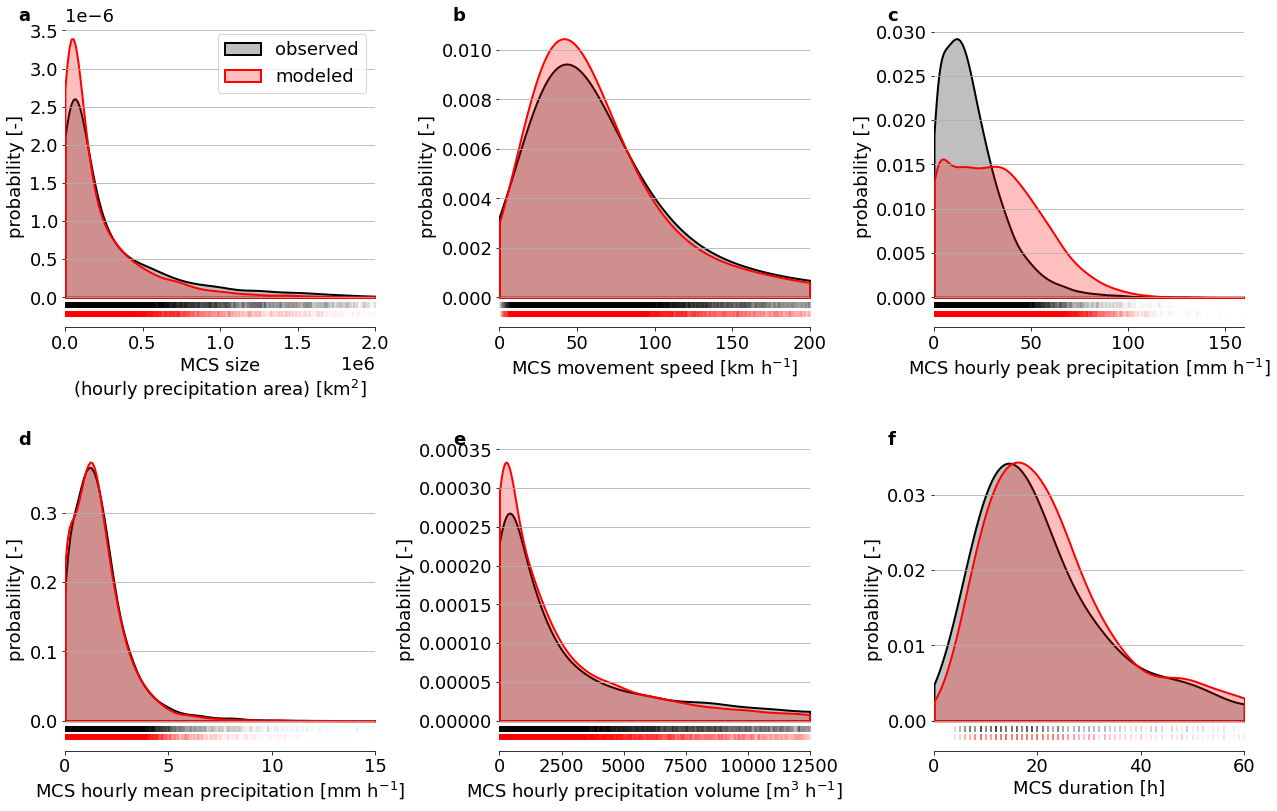

In [12]:
fig = plt.figure(figsize=(18,12))
import seaborn as sns

# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(2,3) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.40, hspace=0.40)

# --------------------------------
# Plot Size Distribution
ax = plt.subplot(gs1[0,0])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, np.max(SIZE_S4/1000**2), 100)
# plot Stage IV
SIZE_S4=SIZE_S4[SIZE_S4 <= SIZE_C2.max()]
p1=sns.kdeplot(SIZE_S4/1000**2, shade=True, color="k", bw=0.2, label='observed', lw=2,cut =0)
# plot CONUS 2
p1=sns.kdeplot(SIZE_C2/1000**2, shade=True, color="red", bw=0.2, label='modeled', lw=2,cut =0)

Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(SIZE_S4/1000**2, np.full_like(SIZE_S4/1000**2, -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(SIZE_C2/1000**2, np.full_like(SIZE_C2/1000**2, -Yrange*0.06), '|r', markeredgewidth=0.05)
plt.legend()
ax.set_xlabel('MCS size\n(hourly precipitation area) [km$^{2}$]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[0], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,2000000))

# --------------------------------
# Plot Movement Distribution
ax = plt.subplot(gs1[0,1])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, 200, 100)
# plot Stage IV
SPEED_S4=SPEED_S4[SPEED_S4 <= SPEED_C2.max()]
p1=sns.kdeplot(SPEED_S4, shade=True, color="k", bw=0.2, label='observed', lw=2, clip=(0,200))
# plot CONUS 2
p1=sns.kdeplot(SPEED_C2, shade=True, color="red", bw=0.2, label='modeled', lw=2, clip=(0,200))
Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(SPEED_S4, np.full_like(SPEED_S4, -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(SPEED_C2, np.full_like(SPEED_C2, -Yrange*0.06), '|r', markeredgewidth=0.05)
ax.set_xlabel('MCS movement speed [km h$^{-1}$]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[1], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,200))


# --------------------------------
# Plot Max Distribution
ax = plt.subplot(gs1[0,2])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, np.max(MAX_S4), 100)
# plot Stage IV
p1=sns.kdeplot(MAX_S4, shade=True, color="k", bw=0.2, label='observed', lw=2, clip=(0,200))
# plot CONUS 2
p1=sns.kdeplot(MAX_C2, shade=True, color="red", bw=0.2, label='modeled', lw=2, clip=(0,200))
Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(MAX_S4, np.full_like(MAX_S4, -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(MAX_C2, np.full_like(MAX_C2, -Yrange*0.06), '|r', markeredgewidth=0.05)
ax.set_xlabel('MCS hourly peak precipitation [mm h$^{-1}$]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[2], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,160))

# --------------------------------
# Plot Mean PR PDF
ax = plt.subplot(gs1[1,0])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, np.max(MEAN_S4), 100)
# plot Stage IV
p1=sns.kdeplot(MEAN_S4, shade=True, color="k", bw=0.2, label='observed', lw=2,cumulative=False, clip=(0,25))
# plot CONUS 2
p1=sns.kdeplot(MEAN_C2, shade=True, color="red", bw=0.2, label='modeled', lw=2,cumulative=False, clip=(0,25))
Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(MEAN_S4, np.full_like(MEAN_S4, -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(MEAN_C2, np.full_like(MEAN_C2, -Yrange*0.06), '|r', markeredgewidth=0.05)
ax.set_xlabel('MCS hourly mean precipitation [mm h$^{-1}$]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[3], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,15))

# --------------------------------
# Plot VOL PR PDF
ax = plt.subplot(gs1[1,1])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, np.max(VOL_S4), 100)
# plot Stage IV
VOL_S4=VOL_S4[VOL_S4 <= VOL_C2.max()]
p1=sns.kdeplot(VOL_S4, shade=True, color="k", bw=0.1, label='observed', lw=2,cumulative=False, clip=(0,12500))
# plot CONUS 2
p1=sns.kdeplot(VOL_C2, shade=True, color="red", bw=0.1, label='modeled', lw=2,cumulative=False, clip=(0,12500))
Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(VOL_S4, np.full_like(VOL_S4, -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(VOL_C2, np.full_like(VOL_C2, -Yrange*0.06), '|r', markeredgewidth=0.05)
ax.set_xlabel('MCS hourly precipitation volume [m$^{3}$ h$^{-1}$]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[4], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,12500))

# --------------------------------
# Plot MCS duration
ax = plt.subplot(gs1[1,2])
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0, np.max(Duration_S4), 100)
# plot Stage IV
p1=sns.kdeplot(Duration_S4, shade=True, color="k", bw=0.2, label='observed', lw=2, clip=(0,60))
# plot CONUS 2
p1=sns.kdeplot(Duration_C2, shade=True, color="red", bw=0.2, label='modeled', lw=2, clip=(0,60))
Yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.plot(Duration_S4, np.full_like(Duration_S4.astype('float'), -Yrange*0.03), '|k', markeredgewidth=0.05)
ax.plot(Duration_C2, np.full_like(Duration_C2.astype('float'), -Yrange*0.06), '|r', markeredgewidth=0.05)
ax.set_xlabel('MCS duration [h]')
ax.set_ylabel('probability [-]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-0.15,1.0, rgsLableABC[5], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.grid(axis='y')
ax.set_xlim((0,60))


### MCS origin and track on maps

        Plot map to: /glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/2010-2019_MCS-Origin-Track_5mm_Sigma3_3000GC.pdf


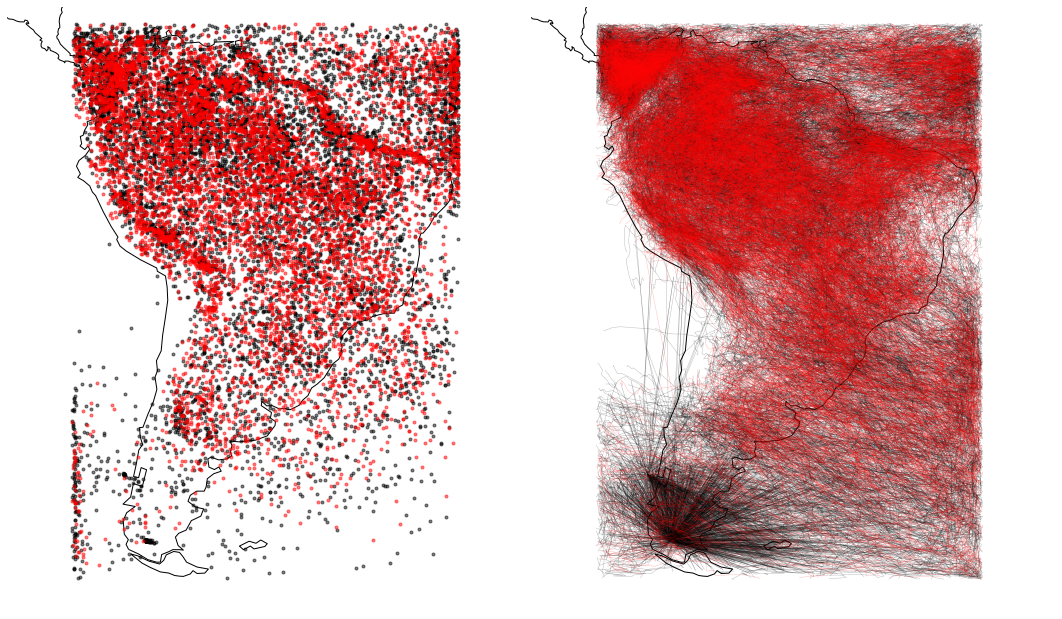

In [13]:
fig = plt.figure(figsize=(16,14))
import seaborn as sns

# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(1,2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.0, hspace=0.40)

# --------------------------------
# Plot the MCS Origin in Stage IV and CONUS404

proj = ccrs.PlateCarree() #ccrs.Robinson() 

ax = plt.subplot(gs1[0,0], projection=proj)
plt.axis('off')
ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
ax.coastlines()

# plot OBS Origin
sS4_MCSs=list(StormLatS4All.keys())
for mc in range(len(sS4_MCSs)):
    try:
        ax.plot(StormLonS4All[sS4_MCSs[mc]][0], StormLatS4All[sS4_MCSs[mc]][0],'ko', markersize=3, alpha=0.5, transform=ccrs.PlateCarree())
    except:
        continue

# plot CONUS404 Origin
sC404_MCSs=list(StormLonC2All.keys())
for mc in range(len(sC404_MCSs)):
    try:
        ax.plot(StormLonC2All[sC404_MCSs[mc]][0], StormLatC2All[sC404_MCSs[mc]][0],'ro', markersize=3, alpha=0.5, transform=ccrs.PlateCarree())
    except:
        continue

    
# ==================================
# Plot the MCS Tracks in Stage IV and CONUS404
ax = plt.subplot(gs1[0,1], projection=proj)
plt.axis('off')
ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
ax.coastlines()

# plot OBS Origin
sS4_MCSs=list(StormLatS4All.keys())
for mc in range(len(sS4_MCSs)):
    ax.plot(StormLonS4All[sS4_MCSs[mc]], StormLatS4All[sS4_MCSs[mc]],'k', markersize=4, alpha=0.25, lw=0.5, transform=ccrs.PlateCarree())

# plot CONUS404 Origin
sC404_MCSs=list(StormLatC2All.keys())
for mc in range(len(sC404_MCSs)):
    plt.plot(StormLonC2All[sC404_MCSs[mc]], StormLatC2All[sC404_MCSs[mc]],'r', markersize=4, alpha=0.25, lw=0.5, transform=ccrs.PlateCarree())
    

# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= str(TimeMM.year[0])+'-'+str(TimeMM.year[-1])+'_MCS-Origin-Track_5mm_Sigma3_3000GC.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
# fig.savefig(sPlotFile+sPlotName, dpi=700)


In [14]:
### read orography from SAAG 
import xarray as xr
ds_disk = xr.open_dataset('/glade/campaign/univ/uiuc0017/chliu/June2018_May2019_nsp/wrfout_d01_2019-06-23_11:00:00')
LonE=np.squeeze(np.array(ds_disk['XLONG']))
LatE=np.squeeze(np.array(ds_disk['XLAT']))
LANDMASK=np.squeeze(np.array(ds_disk['LANDMASK']))
HGT = np.squeeze(np.array(ds_disk['HGT']))

In [15]:
rgsDataSets

['IMERG', 'WRF4km']

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


        Plot map to: /glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/2010-2019_MCS-initiation_frequcney.pdf


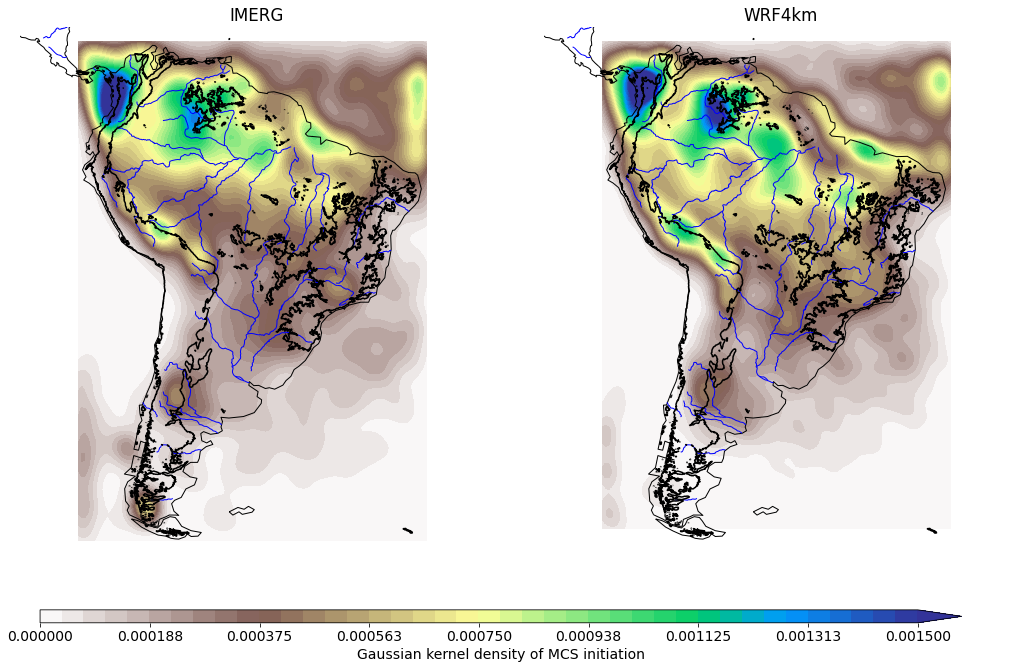

In [16]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

fig = plt.figure(figsize=(16,9))
import seaborn as sns
plt.rcParams.update({'font.size': 14})

# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(1,2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.0, hspace=0.0)

# --------------------------------
# Plot the MCS Origin in Stage IV and CONUS404
proj = ccrs.PlateCarree() #ccrs.Robinson() 

for da in range(len(rgsDataSets)):
    ax = plt.subplot(gs1[0,da], projection=proj)
    plt.axis('off')
    ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')

    if rgsDataSets[da] == 'IMERG':
        DATA_LAT = StormLatS4All
        DATA_LON = StormLonS4All
    else:
        DATA_LAT = StormLatC2All
        DATA_LON = StormLonC2All
        
    # plot OBS Origin
    sS4_MCSs=list(DATA_LAT.keys())

    x = np.array([DATA_LAT[sS4_MCSs[mc]][0] for mc in range(len(list(DATA_LAT.keys())))])
    y = np.array([DATA_LON[sS4_MCSs[mc]][0] for mc in range(len(list(DATA_LON.keys())))])
    data = np.array([y,x])

    k = kde.gaussian_kde(data, bw_method=0.1)
    nbins = 120
    xi, yi = np.mgrid[y.min():y.max():nbins*1j, x.min():x.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # contour
    ax.set_title(rgsDataSets[da])
    cs = ax.contourf(xi, yi, zi.reshape(xi.shape), transform=ccrs.PlateCarree(), cmap="terrain_r", levels=np.linspace(0,0.0015,41), extend='max')
    # ax.contour(xi, yi, zi.reshape(xi.shape), transform=ccrs.PlateCarree())


    # sns.kdeplot(x=y, y=x, cmap="terrain_r", shade=True, thresh=0, bw_adjust=0.2, levels=21)

    plt.contour(LonE,LatE,HGT, ccrs.PlateCarree(), levels=[500],linewidths=1.5, colors='k')

CbarAx = axes([0.1, 0.05, 0.8, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('Gaussian kernel density of MCS initiation') #, fontsize=12)
    
sPlotFile=sPlotDir
sPlotName= str(TimeMM.year[0])+'-'+str(TimeMM.year[-1])+'_MCS-initiation_frequcney.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)


### Read in total and MCS precipitation

In [17]:
rgsYears

['WY2011', 'WY2016', 'WY2019']

In [18]:
rgrPR_total = np.zeros((len(TimeMM), Lon.shape[0], Lon.shape[1], len(rgsDataSets))); rgrPR_total[:] = np.nan
rgrMCS_PR_total = np.copy(rgrPR_total)
NCdataName = ['IMERG-MERGIR','SAAG-WRF4']
for yy in range(len(rgsYears)):
    print('process '+rgsYears[yy])
    for da in range(len(rgsDataSets)):
        if rgsYears[yy] <= 'WY2011': 
            FILE = ST4Data + 'WY2011_' + NCdataName[da]+'_Prein_SAAG-MCS-tracking_Smooth.nc'
        elif rgsYears[yy] <= 'WY2019': 
            FILE = ST4Data + 'WY2019_' + NCdataName[da]+'_Prein_SAAG-MCS-tracking_Smooth.nc'
        elif rgsYears[yy] <= 'WY2016':
            FILE = ST4Data + 'WY2016_' + NCdataName[da]+'_Prein_SAAG-MCS-tracking_Smooth.nc'
        ds_disk = xr.open_dataset(FILE)
        PR=np.array(ds_disk['PR'])
        MCSlabel=np.array(ds_disk['MCS_objects'])
        BTlabel=np.array(ds_disk['BT_objects'])
        BT_MCSs = np.unique(BTlabel[MCSlabel >= 0])[1:]
        BT_MCSs = np.isin(BTlabel,BT_MCSs)        
        rgrPR_total[mm,:,:,da] = np.sum(PR, axis=0)
        PR[BT_MCSs == 0] = 0
        rgrMCS_PR_total[mm,:,:,da] = np.sum(PR, axis=0)

process WY2011
process WY2016
process WY2019


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


        Plot map to: /glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/2010-2019_MCS-precipitation-ratio.pdf


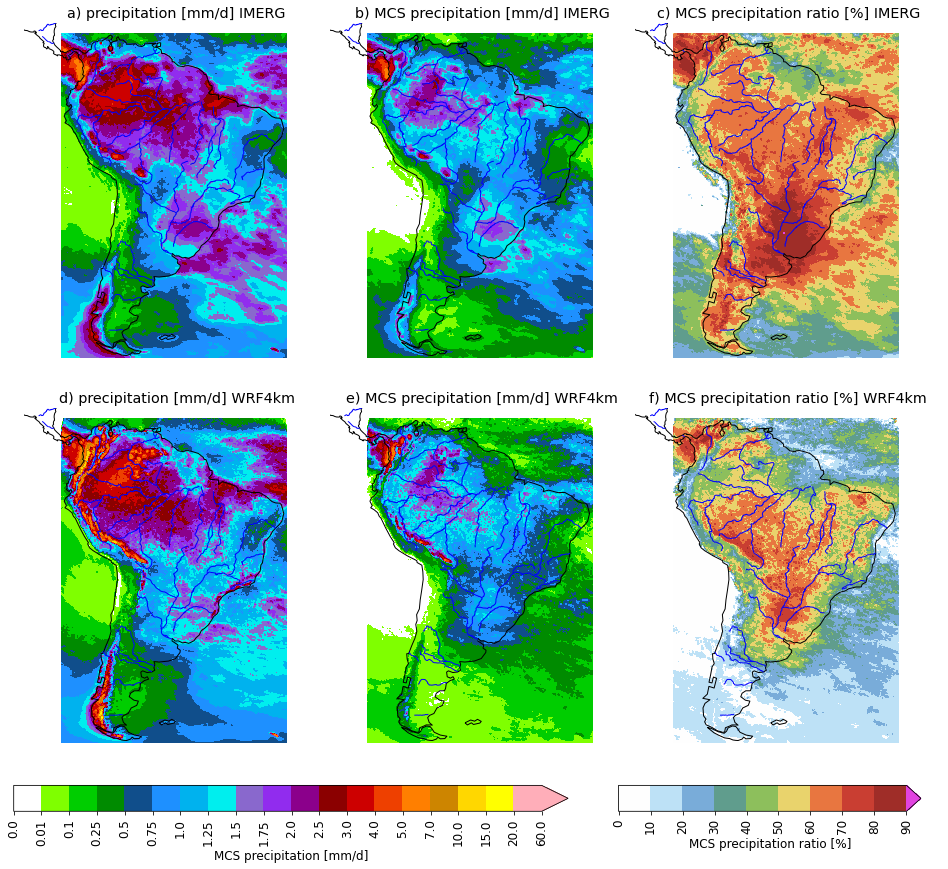

In [19]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm


import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')



fig = plt.figure(figsize=(14,12))
import seaborn as sns
plt.rcParams.update({'font.size': 12})
# Histogram plots
rgiSize=MCSsPerMonthS4.shape
gs1 = gridspec.GridSpec(2,3) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.1, top=0.97,
           wspace=0.0, hspace=0.05)

# --------------------------------
# Plot the MCS Origin in Stage IV and CONUS404
proj = ccrs.PlateCarree() #ccrs.Robinson() 

Stats = ['precipitation [mm/d]', 'MCS precipitation [mm/d]', 'MCS precipitation ratio [%]']
for st in range(len(Stats)):
    for da in range(len(rgsDataSets)):
        if st == 0:
            DATA = np.nansum(rgrPR_total[:,:,:,da], axis=0)/(365*3)
            COLORS = ["#ffffff", "#7fff00", "#00cd00", "#008b00", "#104e8b",
               "#1e90ff", "#00b2ee", "#00eeee", "#8968cd", "#912cee",
               "#8b008b", "#8b0000", "#cd0000", "#ee4000", "#ff7f00",
               "#cd8500", "#ffd700", "#ffff00", "#ffaeb9"]
            LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
               2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
        elif st == 1:
            DATA = np.nansum(rgrMCS_PR_total[:,:,:,da], axis=0)/(365*3)
        elif st == 2:
            DATA = (np.nansum(rgrMCS_PR_total[:,:,:,da], axis=0) / np.nansum(rgrPR_total[:,:,:,da], axis=0))*100
#             LEVS =np.array([2,5,10,15,20,25,30,40,50,70,100])
#             COLORS = ['#ffffff','#afdbef','#5a96c6','#64ab5f','#eadf6d','#e9813d','#c93d35','#962722',
#                   '#7a0177','#c51b8a','#f768a1','#fa9fb5','#fcc5c0']#,'#ea43f1']
            COLORS = ['#fefefe','#bde1f6','#79acd9','#609d8d','#8dbf5c','#e9d36c',
                      '#e87640','#c93e32','#9f2d28','#e243e1']
            LEVS =np.array([0,10,20,30,40,50,60,70,80,90])
        
        
        
        ax = plt.subplot(gs1[da,st], projection=proj)
        plt.axis('off')
        ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')

        # contour
        ax.set_title(rgsLableABC[st+da*3]+') '+Stats[st]+' '+rgsDataSets[da])
        cs = ax.contourf(Lon, Lat, DATA, transform=ccrs.PlateCarree(), colors=COLORS, levels=LEVS, extend='max')

    pos1 = ax.get_position()
    if st == 1:
        CbarAx = axes([0.05, 0.05, 0.55, 0.03])
    if st == 2:
        CbarAx = axes([0.65, 0.05, 0.3, 0.03])
    if st >= 1:
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=LEVS)
        cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label(Stats[st]) #, fontsize=12)

sPlotFile=sPlotDir
sPlotName= str(TimeMM.year[0])+'-'+str(TimeMM.year[-1])+'_MCS-precipitation-ratio.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)

### Movie that shows tracks in animation

In [20]:
sPlotFile+sPlotName

'/glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Tracking_Analysis/plots/2010-2019_MCS-precipitation-ratio.pdf'

In [21]:
HHlag = 7*24 # 14 day lag before the track fades

FocusTime = rgdTimeST4 #pd.date_range(datetime.datetime(2018, 11, 1,0), end=datetime.datetime(2018, 11, 30,23), freq='h')

S4MCStime = np.array(S4MCStime)
for hh in range(2000,2100,1)[::4]: #np.where(FocusTime.month >= 0)[0][::4]:  #range(1,len(FocusTime),1):
    sPlotFile='/glade/u/home/prein/papers/2020_SouthAmerica/plots/MCS_Animation/'
    sPlotName= str(hh).zfill(4)+'_MCS-IMERG-WRF-SA4km_'+str(FocusTime[hh])[:10]+'.jpg'
    if os.path.exists(sPlotFile+sPlotName) == False:

        proj = ccrs.PlateCarree() #ccrs.Robinson() 
    
        fig = plt.figure(figsize=(7,9))

        gs1 = gridspec.GridSpec(1,1)
        gs1.update(left=0.06, right=0.97,
                   bottom=0.05, top=0.95,
                   wspace=0.40, hspace=0.40)
        ax = plt.subplot(gs1[0,0], projection=proj)
        plt.axis('off')
        ax.set_extent((-90, -25, -60, 15), ccrs.PlateCarree())
        ax.coastlines()


        if hh-HHlag < 0:
            start = 0
        else:
            start = hh-HHlag
        # plot Stage 4
        rgiMCSs = np.array([(S4MCStime[ii] <= iTimeS4[hh]) & (S4MCStime[ii] >= iTimeS4[start]) for ii in range(len(S4MCStime))])
        iMCSs = np.array([np.max(rgiMCSs[ii]) for ii in range(len(rgiMCSs))])
        if np.sum(iMCSs == True) > 0:
            SelMCS = np.array(S4MCStime)[(iMCSs == True)]
            LatSel = np.array(S4LatMCS)[np.where(iMCSs == True)]
            LonSel = np.array(S4LonMCS)[np.where(iMCSs == True)]
            for mc in range(SelMCS.shape[0]):
                TTact = SelMCS[mc]
                iTact = TTact[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]
                try:
                    LonAct = np.array(LonSel[mc])[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]
                    LatAct = np.array(LatSel[mc])[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]

                    ALPHA = 1-np.array(iTimeS4[hh]-iTact)/HHlag
                    LineWIDTH = ALPHA*3
                    for tt in range(len(LonAct)-1):
                        ax.plot([LonAct[tt],LonAct[tt+1]],[LatAct[tt],LatAct[tt+1]], c='k', lw=LineWIDTH[tt], alpha=ALPHA[tt], transform=ccrs.PlateCarree())
                except:
                    continue
        # plot CONUS404
        rgiMCSs = np.array([(C2MCStime[ii] <= iTimeS4[hh]) & (C2MCStime[ii] >= iTimeS4[start]) for ii in range(len(C2MCStime))])
        iMCSs = np.array([np.max(rgiMCSs[ii]) for ii in range(len(rgiMCSs))])
        if np.sum(iMCSs == True) > 0:
            SelMCS = np.array(C2MCStime)[(iMCSs == True)]
            LatSel = np.array(C2LatMCS)[np.where(iMCSs == True)]
            LonSel = np.array(C2LonMCS)[np.where(iMCSs == True)]
            for mc in range(SelMCS.shape[0]):
                TTact = SelMCS[mc]
                iTact = TTact[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]
                try:
                    LonAct = np.array(LonSel[mc])[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]
                    LatAct = np.array(LatSel[mc])[(TTact <= iTimeS4[hh]) & (TTact >= iTimeS4[start])]

                    ALPHA = 1-np.array(iTimeS4[hh]-iTact)/HHlag
                    LineWIDTH = ALPHA*3
                    for tt in range(len(LonAct)-1):
                        ax.plot([LonAct[tt],LonAct[tt+1]],[LatAct[tt],LatAct[tt+1]], c='#e31a1c', lw=LineWIDTH[tt], alpha=ALPHA[tt], transform=ccrs.PlateCarree())
                except:
                    continue    

        plt.title(str(FocusTime[hh])[:10], fontsize=14)

        # Save the plot
        if os.path.isdir(sPlotFile) != 1:
            subprocess.call(["mkdir","-p",sPlotFile])
        print( '        Plot map to: '+sPlotFile+sPlotName)
        fig.savefig(sPlotFile+sPlotName) #, dpi=700)
